Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path ='/content/drive/MyDrive/Colab Notebooks/'
data_dir_train = pathlib.Path(root_path+"data/Train")
data_dir_test = pathlib.Path(root_path+'data/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

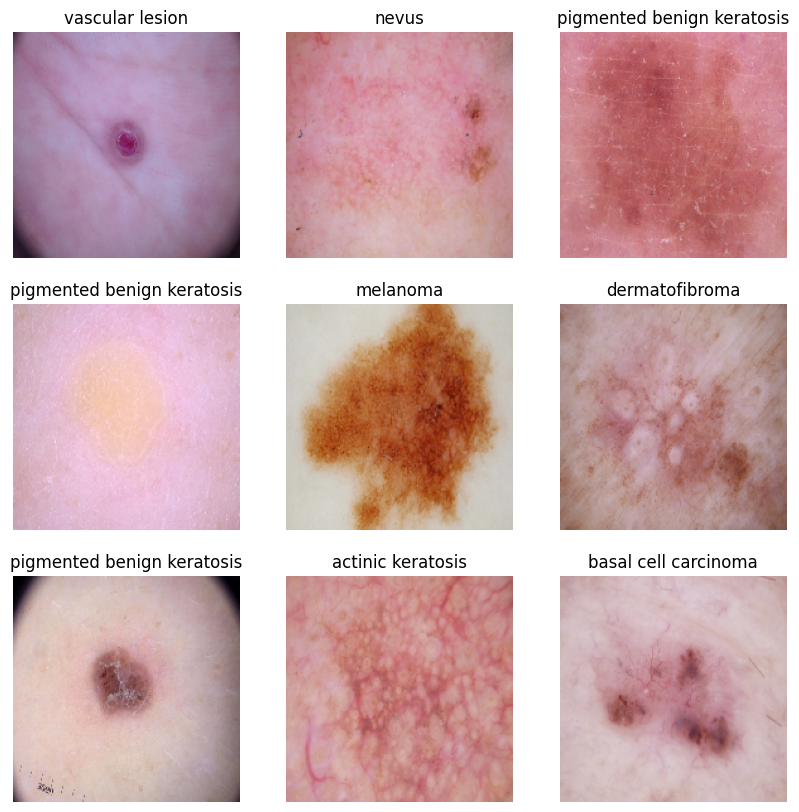

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 272s 141ms/step - loss: 2.0488 - accuracy: 0.1897 - val_loss: 2.4094 - val_accuracy: 0.0000e+00
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 2.0157 - accuracy: 0.2148 - val_loss: 2.3239 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.9983 - accuracy: 0.2533 - val_loss: 2.3220 - val_accuracy: 0.1304
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9562 - accuracy: 0.2667 - val_loss: 2.3696 - val_accuracy: 0.1739
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9231 - accuracy: 0.2785 - val_loss: 2.2414 - val_accuracy: 0.2174
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8836 - accuracy: 0.3019 - val_loss: 2.2099 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.8485 - accuracy: 0.3393 - val_loss: 2.3194 - val_accuracy: 0.2174
Epoch 

### Visualizing training results

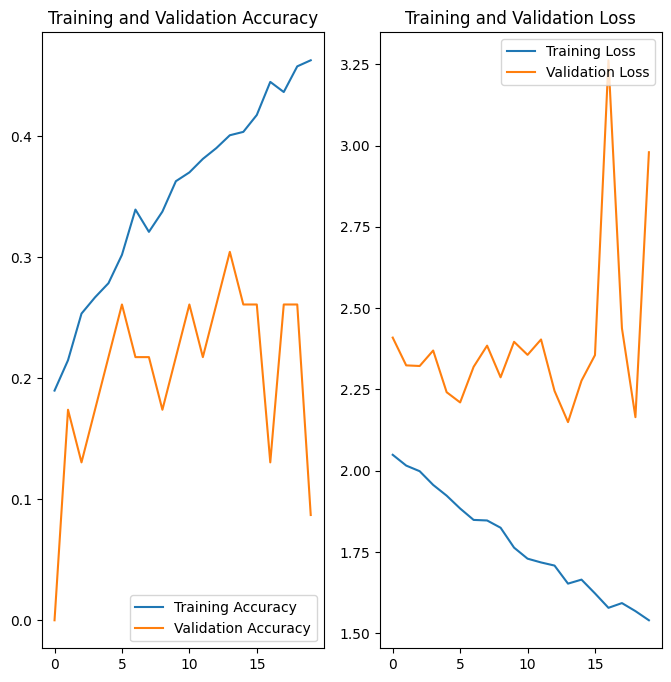

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

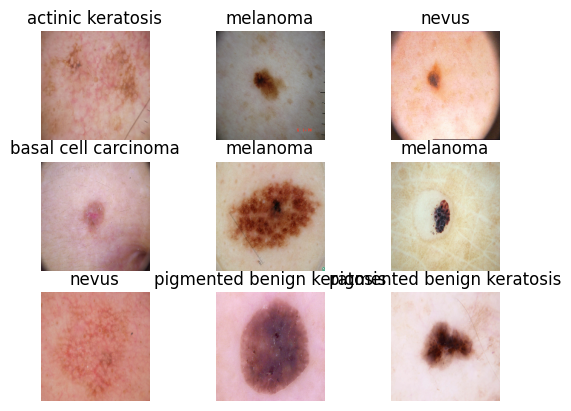

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
    layers.Input((img_height, img_width, 3)),
    data_augmentation, # Add augmentation layers first
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [19]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 32ms/step - loss: 2.0424 - accuracy: 0.2042 - val_loss: 2.3900 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 2.0061 - accuracy: 0.2427 - val_loss: 2.3649 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.9783 - accuracy: 0.2712 - val_loss: 2.3091 - val_accuracy: 0.0870
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.9714 - accuracy: 0.2640 - val_loss: 2.4154 - val_accuracy: 0.0435
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.9078 - accuracy: 0.2941 - val_loss: 2.3149 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.9767 - accuracy: 0.2695 - val_loss: 2.1522 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8541 - accuracy: 0.3248 - val_loss: 2.2318 - val_accuracy: 0.2609
Epoch 8/20
56

### Training the model

### Visualizing the results

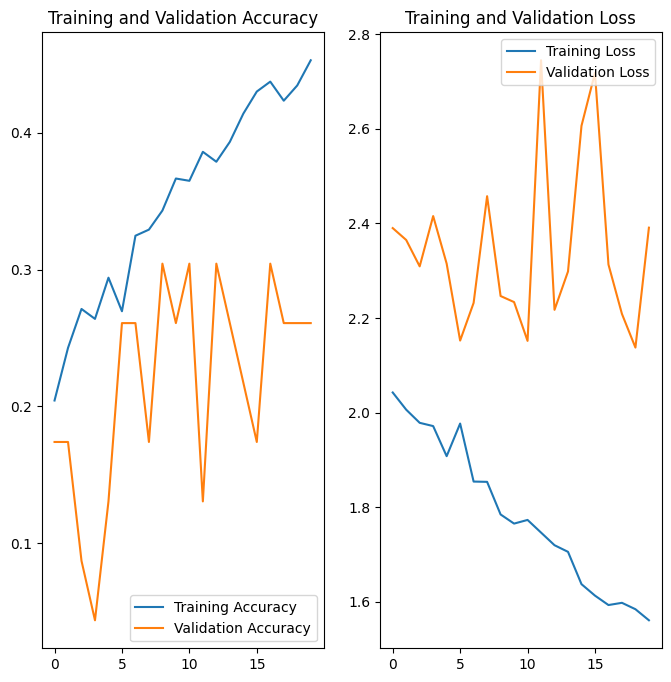

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Findings ###

Though we do see that after adding dropout and data augmetation the train accuracy have come down. But we also do see that the validation accuracy has increased. So this looks like there is less overfitting

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.
for c in class_names:
  print(c)
  print(len(list(data_dir_train.glob(c+'/*.jpg'))))

actinic keratosis
114
basal cell carcinoma
376
dermatofibroma
95
melanoma
438
nevus
357
pigmented benign keratosis
462
seborrheic keratosis
77
squamous cell carcinoma
181
vascular lesion
139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? - At present we see that seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples? - At present melanoma dominates the data with highest number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
str(data_dir_train)

'/content/drive/MyDrive/Colab Notebooks/data/Train'

In [29]:
path_to_training_dataset=str(data_dir_train)+"/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B9032543A30>: 100%|██████████| 500/500 [00:17<00:00, 28.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B90405B86D0>: 100%|██████████| 500/500 [00:22<00:00, 22.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B90325AFD90>: 100%|██████████| 500/500 [00:20<00:00, 23.88 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B9032502F80>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B9040601B40>: 100%|██████████| 500/500 [01:16<00:00,  6.52 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B90325DAFE0>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B90B43AB280>: 100%|██████████| 500/500 [00:40<00:00, 12.20 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B90406A2860>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B90B43AB280>: 100%|██████████| 500/500 [00:20<00:00, 24.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output/melanoma_original_ISIC_0010148.jpg_63aa56e1-7a11-4384-9b2e-55210a8ed969.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output/melanoma_original_ISIC_0009913.jpg_fe8ce446-54c3-4e35-a08d-30c3ee45df6f.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output/melanoma_original_ISIC_0001124.jpg_c39522a1-92b2-464c-aa3f-9037725ea848.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output/melanoma_original_ISIC_0000158.jpg_0470f0ae-0fba-4ab7-a560-5577199e2913.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output/melanoma_original_ISIC_0011187.jpg_d1e5cd1e-f38f-4f9d-96f8-b5f35fe88c8c.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output/melanoma_original_ISIC_0010394.jpg_636a48f7-5dbc-4441-bd64-00a67c9a66e4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/Train/melanoma/output/melanoma_original_ISIC_0010000.jpg_b1832c8c-738a-4110-91

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = train_ds.append(df2)

AttributeError: '_PrefetchDataset' object has no attribute 'append'

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
str(data_dir_train)+"/*"

'/content/drive/MyDrive/Colab Notebooks/data/Train/*'

In [44]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here
model = Sequential([
    layers.Input((img_height, img_width, 3)),
    data_augmentation, # Add augmentation layers first
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [50]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 66s 371ms/step - loss: 2.1707 - accuracy: 0.1626 - val_loss: 2.1505 - val_accuracy: 0.1967
Epoch 2/30
169/169 [==============================] - 44s 252ms/step - loss: 2.0975 - accuracy: 0.2081 - val_loss: 2.0354 - val_accuracy: 0.2383
Epoch 3/30
169/169 [==============================] - 41s 235ms/step - loss: 1.9897 - accuracy: 0.2452 - val_loss: 1.8627 - val_accuracy: 0.3007
Epoch 4/30
169/169 [==============================] - 40s 229ms/step - loss: 1.9215 - accuracy: 0.2691 - val_loss: 1.8186 - val_accuracy: 0.2791
Epoch 5/30
169/169 [==============================] - 41s 236ms/step - loss: 1.8453 - accuracy: 0.3110 - val_loss: 1.8214 - val_accuracy: 0.3333
Epoch 6/30
169/169 [==============================] - 40s 230ms/step - loss: 1.7551 - accuracy: 0.3474 - val_loss: 1.6397 - val_accuracy: 0.4157
Epoch 7/30
169/169 [==============================] - 40s 229ms/step - loss: 1.6752 - accuracy: 0.3644 - val_loss: 1.5927 - val_ac

#### **Todo:**  Visualize the model results

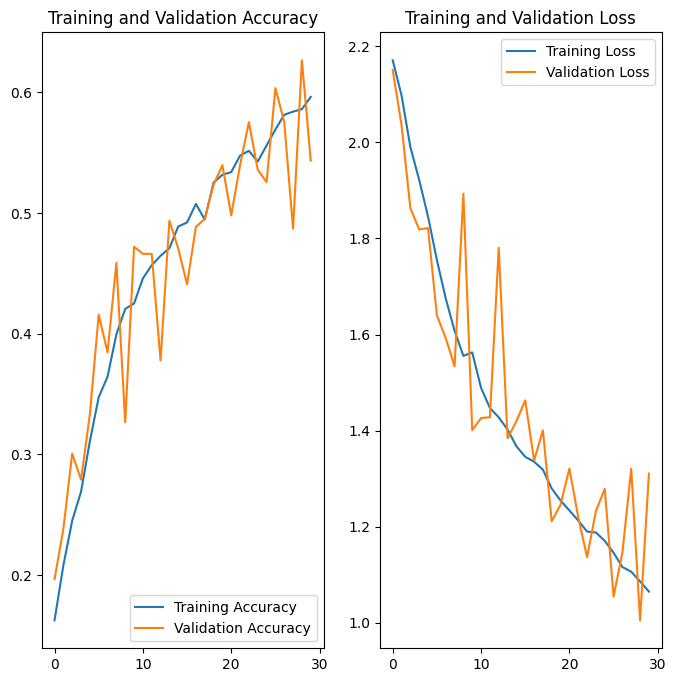

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



So here are the observations -


*   We see that the validation and trainin accuracy is almost consistant and the graph is going up.
*   This means the model acuracy is increasing with each iteration and since both the graphs (validation and training) overlaps we can say that the model is not overfitting.
*   Similar trend can be seen in loss as well. The loss has decreased consistantly for each iteration.

